In [182]:
import numpy as np
import matplotlib.pyplot as plt

In [183]:
T = 2000
n_choices = 2
n_players = 2
eta = 0.01
epsilon = 0.5

In [186]:
def run(eta):
    sum_u = [0, 0]
    x = np.full((2, 2), 0.5, dtype=float)
    s = [0] * n_players
    regret = np.zeros((n_players, T))
    U = np.zeros((n_players, n_choices))
    for t in range(T):
        for i in range(n_players):
            s[i] = np.random.choice([0, 1], p=x[i])
        outcome = 1 if s[0] == s[1] else -1
        for i, coef in enumerate([1, -1]):
            update = coef * outcome
            sum_u[i] += update
            U[i][s[i]] += update
            x[i, s[i]] *= np.exp(eta * update)
            x[i] /= x[i].sum()
        best_in_hind = np.argmax(U, axis=1)
        for i in range(n_players):
            regret[i, t] = U[i, best_in_hind[i]] - sum_u[i]
    return regret

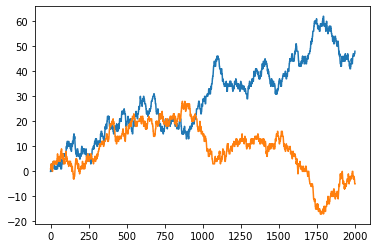

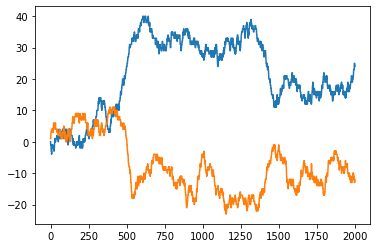

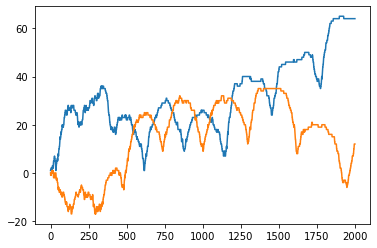

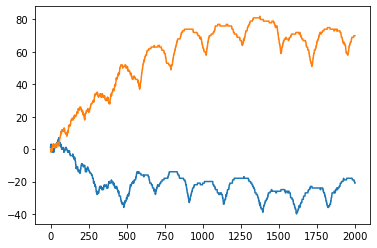

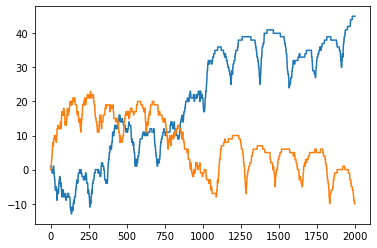

In [190]:
for eta in [0.001, 0.02, 0.03, 0.04, 0.05]:
    regret = run(eta)
    for i in range(n_players):
        plt.plot(np.arange(T), regret[i])
    plt.show()